<a href="https://colab.research.google.com/github/crystaljwang/tm10007_group_3/blob/preprocessing/preprocessing_Crystal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the GIST data from GitHub

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


In [2]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 83 (delta 13), reused 12 (delta 12), pack-reused 62
Unpacking objects: 100% (83/83), 67.93 MiB | 7.32 MiB/s, done.


In [3]:
%cd /content/tm10007_ml/worcgist

/content/tm10007_ml/worcgist


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [5]:
dir = Path('.') / 'GIST_radiomicFeatures.csv'
data = pd.read_csv(dir, index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
data.info()

The number of samples: 246
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, GIST-001_0 to GIST-246_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 951.3+ KB


Splitting the data

In [30]:
# ----- SPLITTING THE DATA -----

# Replace label values from string to binary
data['label'] = data['label'].replace({'GIST': 1, 'non-GIST': 0})

# Separate the features and labels
X = data.drop(['label'], axis=1)
y = data['label']

# Split the data into random train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

# ----- PREPROCESSING -----

# Data scaling
X_train = StandardScaler().fit_transform(X_train)

# Remove all constant (zero-variance) features
X_train = pd.DataFrame(X_train)

zero_var_filter = VarianceThreshold(threshold=0)
zero_var_filter.fit(X_train)
zero_var_columns = [column for column in X_train.columns if column not in X_train.columns[zero_var_filter.get_support()]]
X_train = zero_var_filter.transform(X_train)

removed_features = [data.columns[index] for index in zero_var_columns]
print('The following constant features were removed:')
for feature in removed_features:
    print(f'- {feature}')

(196, 493)
(50, 493)
The following constant features were removed:
- PREDICT_original_tf_LBP_min_R3_P12
- PREDICT_original_tf_LBP_kurtosis_R3_P12
- PREDICT_original_tf_LBP_peak_R3_P12
- PREDICT_original_tf_LBP_min_R8_P24
- PREDICT_original_tf_LBP_peak_R8_P24
- PREDICT_original_tf_LBP_min_R15_P36
- PREDICT_original_tf_LBP_peak_R15_P36
- PREDICT_original_phasef_monogenic_entropy_WL3_N5
- PREDICT_original_phasef_phasecong_kurtosis_WL3_N5
- PREDICT_original_phasef_phasecong_peak_WL3_N5
- PREDICT_original_phasef_phasecong_entropy_WL3_N5
- PREDICT_original_phasef_phasesym_kurtosis_WL3_N5
- PREDICT_original_phasef_phasesym_peak_WL3_N5


Adding a learning curve for cross-validation

In [31]:
# Cross-validation

from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC

train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel='linear'), X_train, y_train, cv=5)
print(train_sizes)
print(train_scores)
print(valid_scores)

[ 15  50  85 120 156]
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[0.55       0.51282051 0.58974359 0.58974359 0.46153846]
 [0.5        0.48717949 0.61538462 0.64102564 0.41025641]
 [0.5        0.53846154 0.64102564 0.79487179 0.53846154]
 [0.55       0.69230769 0.66666667 0.66666667 0.51282051]
 [0.675      0.66666667 0.56410256 0.74358974 0.53846154]]


The selected 10 best features are:
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.0mean
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.0std
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.79mean
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.79std
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A1.57mean
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A1.57std
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A2.36mean
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A2.36std
- PREDICT_original_tf_Gabor_mean_F0.2_A0.79
- PREDICT_original_tf_Gabor_mean_F0.5_A0.79


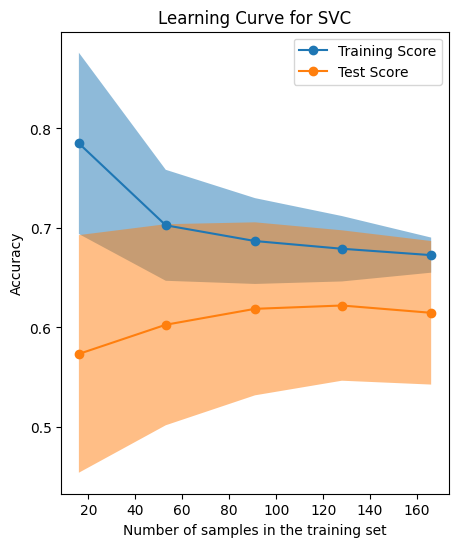

In [32]:
# Select features according to the k highest scores
kbest_filter = SelectKBest(f_classif, k=10)
kbest_filter.fit(X_train, y_train)

data_new = data.drop(data.columns[zero_var_columns], axis=1)
del data_new[data_new.columns[0]]
kbest_list = kbest_filter.get_feature_names_out(input_features=data_new.columns)

print('The selected 10 best features are:')
for kbest in kbest_list:
    print(f'- {kbest}')

X_train = kbest_filter.transform(X_train)

from sklearn.svm import SVC

svc = SVC(kernel="linear")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 6))

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.15, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(svc, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {svc.__class__.__name__}")
plt.show()